# Example of KEO Taylor series expansion for ammonia

Here we use the following internal coordinates

1. $r_1$
2. $r_2$
3. $r_3$
4. $s_4 = (2\alpha_{23}-\alpha_{13}-\alpha_{12})/\sqrt{6}$
5. $s_5 = (\alpha_{13}-\alpha_{12})/\sqrt{2}$
6. $\tau$

where $r_i\equiv\text{N-H}_i$, $\alpha_{ij}\equiv\text{H}_i\text{-C-H}_j$, and $\tau$ is an 'umbrella' angle measured from the planar configuration.

In [1]:
import itertools

import jax
import matplotlib.pyplot as plt
import numpy as np
from jax import config
from jax import numpy as jnp

from vibrojet.keo import Gmat, com, pseudo
from vibrojet.potentials import nh3_POK
from vibrojet.taylor import deriv_list

config.update("jax_enable_x64", True)

Define a function `find_alpha_from_s_delta` to obtain three $\alpha_{ij}$ valence angular coordinates from the two symmetrized $s_4$, $s_5$ and 'umbrella' angle $\tau$ coordinates, defined above

In [2]:
def find_alpha_from_s_delta(s4, s5, delta, no_iter: int = 20):

    def calc_s_to_sin_delta(s6, s4, s5):
        alpha1 = (jnp.sqrt(2) * s6 + 2.0 * s4) / jnp.sqrt(6)
        alpha2 = (jnp.sqrt(2) * s6 - s4 + jnp.sqrt(3) * s5) / jnp.sqrt(6)
        alpha3 = (jnp.sqrt(2) * s6 - s4 - jnp.sqrt(3) * s5) / jnp.sqrt(6)
        tau_2 = (
            1
            - jnp.cos(alpha1) ** 2
            - jnp.cos(alpha2) ** 2
            - jnp.cos(alpha3) ** 2
            + 2 * jnp.cos(alpha1) * jnp.cos(alpha2) * jnp.cos(alpha3)
        )
        norm_2 = (
            jnp.sin(alpha3) ** 2
            + jnp.sin(alpha2) ** 2
            + jnp.sin(alpha1) ** 2
            + 2 * jnp.cos(alpha3) * jnp.cos(alpha1)
            - 2 * jnp.cos(alpha2)
            + 2 * jnp.cos(alpha2) * jnp.cos(alpha3)
            - 2 * jnp.cos(alpha1)
            + 2 * jnp.cos(alpha2) * jnp.cos(alpha1)
            - 2 * jnp.cos(alpha3)
        )
        return tau_2 / norm_2

    # initial value for s6
    alpha1 = 2 * jnp.pi / 3
    s6 = alpha1 * jnp.sqrt(3)
    sin_delta = jnp.sin(delta)

    for _ in range(no_iter):
        f = calc_s_to_sin_delta(s6, s4, s5)
        eps = f - sin_delta**2
        grad = jax.grad(calc_s_to_sin_delta)(s6, s4, s5)
        dx = eps / grad
        dx0 = dx
        s6 = s6 - dx0

    alpha1 = (jnp.sqrt(2) * s6 + 2 * s4) / jnp.sqrt(6)
    alpha2 = (jnp.sqrt(2) * s6 - s4 + jnp.sqrt(3) * s5) / jnp.sqrt(6)
    alpha3 = (jnp.sqrt(2) * s6 - s4 - jnp.sqrt(3) * s5) / jnp.sqrt(6)

    return alpha1, alpha2, alpha3

In [3]:
masses = [
    14.00307400,
    1.007825035,
    1.007825035,
    1.007825035,
]  # masses of N, H1, H2, H3

# reference values of internal coordinates
r_ref = 1.01031310
rho_ref = 1.956454767
tau_ref = 0  # rho_ref - np.pi / 2
q0 = [r_ref, r_ref, r_ref, 0.0, 0.0, tau_ref]


@com(masses)
def internal_to_cartesian(internal_coords):
    r1, r2, r3, s4, s5, delta = internal_coords
    alpha1, alpha2, alpha3 = find_alpha_from_s_delta(s4, s5, delta)
    rho = jnp.pi / 2 + delta

    beta3 = jnp.acos((jnp.cos(alpha3) - jnp.cos(rho) ** 2) / jnp.sin(rho) ** 2)
    beta2 = jnp.acos((jnp.cos(alpha2) - jnp.cos(rho) ** 2) / jnp.sin(rho) ** 2)
    cartesian = jnp.array(
        [
            [0.0, 0.0, 0.0],
            [r1 * jnp.sin(rho), 0.0, r1 * jnp.cos(rho)],
            [
                r2 * jnp.sin(rho) * jnp.cos(beta3),
                r2 * jnp.sin(rho) * jnp.sin(beta3),
                r2 * jnp.cos(rho),
            ],
            [
                r3 * jnp.sin(rho) * jnp.cos(beta2),
                -r3 * jnp.sin(rho) * jnp.sin(beta2),
                r3 * jnp.cos(rho),
            ],
        ]
    )
    return cartesian

In [4]:
xyz = internal_to_cartesian(q0)
print("Reference internal coordinates:\n", q0)
print("Reference Cartesian coordinates:\n", xyz)

Reference internal coordinates:
 [1.0103131, 1.0103131, 1.0103131, 0.0, 0.0, 0]
Reference Cartesian coordinates:
 [[ 2.85580222e-17  2.96388443e-19 -1.09854184e-17]
 [ 1.01031310e+00  2.96388443e-19  5.08784168e-17]
 [-5.05156550e-01  8.74956810e-01  5.08784168e-17]
 [-5.05156550e-01 -8.74956810e-01  5.08784168e-17]]


In [ ]:
@jax.jit
def poten(internal_coords):
    r1, r2, r3, s4, s5, delta = internal_coords
    alpha1, alpha2, alpha3 = find_alpha_from_s_delta(s4, s5, delta)
    v = nh3_POK.poten((r1, r2, r3, alpha1, alpha2, alpha3))
    return v

batch_poten = jax.jit(jax.vmap(poten, in_axes=0))


max_order = 4  # max total expansion order
deriv_ind = [
    elem
    for elem in itertools.product(*[range(0, max_order + 1) for _ in range(len(q0))])
    if sum(elem) <= max_order
]
print("max expansion order:", max_order)
print("number of expansion terms:", len(deriv_ind))

poten_coefs = deriv_list(poten, deriv_ind, q0, if_taylor=True)

tau = np.linspace(-70/180*np.pi, 70/180*np.pi)
q = np.ones((len(tau),6)) * np.array(q0)[None,:]
q[:,-1] = tau
v = batch_poten(q)
print(v)

max expansion order: 4
number of expansion terms: 210


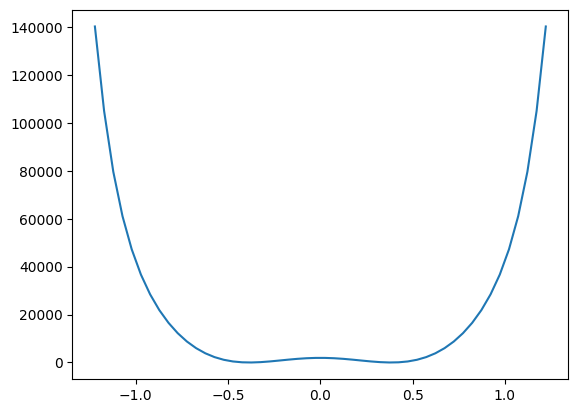

In [ ]:
plt.plot(q[:,-1], v)
# print(q.shape, v.shape)